For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
#percent = 0.5
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = percent
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [9]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [10]:
mask = None

In [11]:
intensity = IntensityRescale(masked=False)

In [12]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


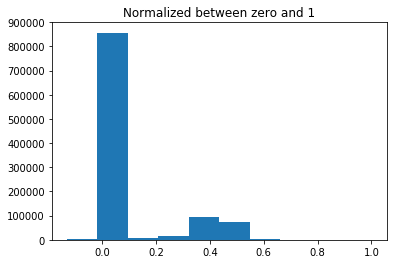

In [13]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


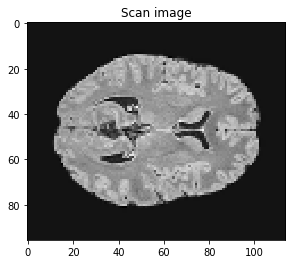

In [14]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [15]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [16]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_8.h5"
#model_path = "/analysis/fabiane/models/ADNI/Felix/retrain_emily_version/dropout0.3_lr0.001_dc0_l20.01_20181119-163525_weights_ep04_vacc0.87.hdf5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [17]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [18]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [19]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0012513805413618684


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/image.py:419: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


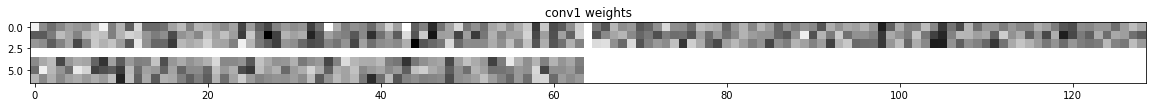

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.0010271043283864856


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/image.py:412: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


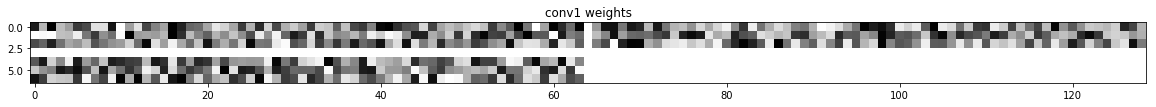

In [20]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [21]:
X_train.shape

(124, 96, 114, 96)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


27/27 [==============================] - 8s 308ms/step - loss: 0.9807 - acc: 0.4912 - val_loss: 0.8352 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.8419 - acc: 0.6200 - val_loss: 0.7785 - val_acc: 0.6842

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 166ms/step - loss: 0.9393 - acc: 0.5376 - val_loss: 0.8346 - val_acc: 0.4737

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8608 - acc: 0.5190 - val_loss: 0.9117 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 166ms/step - loss: 0.8783 - acc: 0.4634 - val_loss: 0.7572 - val_acc: 0.6842

Epoch 00005: val_a

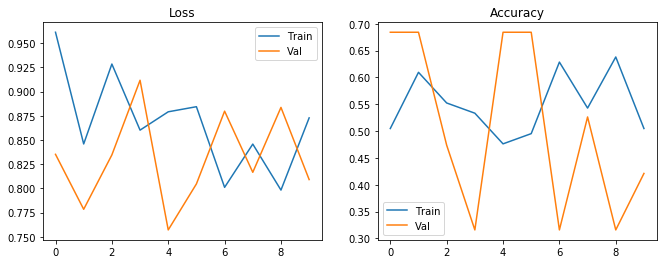

Trial 1
Epoch 1/200
27/27 [==============================] - 6s 223ms/step - loss: 1.1714 - acc: 0.4439 - val_loss: 0.8101 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9412 - acc: 0.5644 - val_loss: 0.7806 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.68421 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial1-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9212 - acc: 0.4727 - val_loss: 0.8100 - val_acc: 0.7895

Epoch 00003: val_acc improved from 0.68421 to 0.78947, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial1-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 152ms/

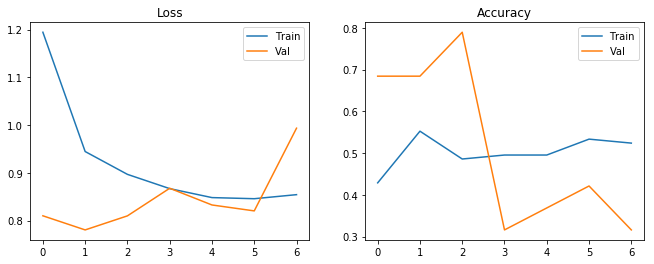

Trial 2
Epoch 1/200
27/27 [==============================] - 6s 217ms/step - loss: 0.9829 - acc: 0.4264 - val_loss: 0.8138 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 157ms/step - loss: 0.9010 - acc: 0.4912 - val_loss: 0.8123 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.68421 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial2-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 157ms/step - loss: 0.8977 - acc: 0.5005 - val_loss: 0.8197 - val_acc: 0.6842

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 158ms/step - loss: 0.8842 - acc: 0.5551 - val_loss: 0.7981 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.68421
Epoch

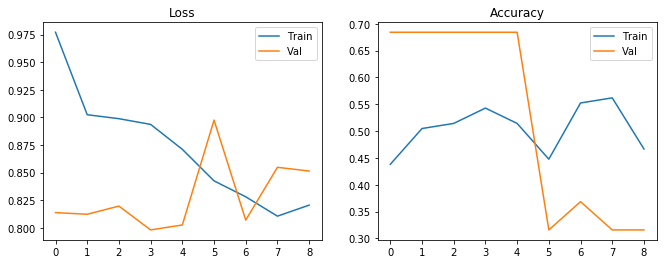

Trial 3
Epoch 1/200
27/27 [==============================] - 6s 219ms/step - loss: 1.0429 - acc: 0.4346 - val_loss: 0.8353 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9676 - acc: 0.4634 - val_loss: 0.8445 - val_acc: 0.3684

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.8816 - acc: 0.4356 - val_loss: 0.8812 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 160ms/step - loss: 0.8916 - acc: 0.4995 - val_loss: 0.8909 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 166ms/step - loss: 0.8763 - acc: 0.5366 - val_loss: 0.9027 - val_acc: 0.3158

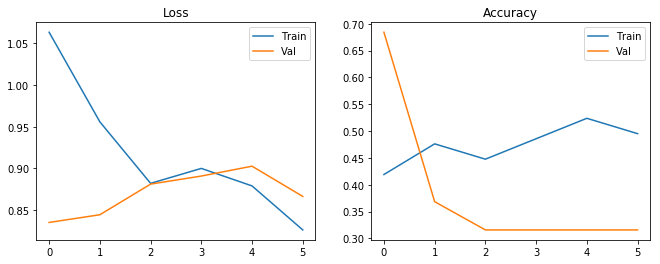

Trial 4
Epoch 1/200
27/27 [==============================] - 6s 235ms/step - loss: 1.0026 - acc: 0.5180 - val_loss: 0.8291 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 152ms/step - loss: 0.9002 - acc: 0.5190 - val_loss: 0.8041 - val_acc: 0.6842

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9625 - acc: 0.4902 - val_loss: 0.7769 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.68421 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial4-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.9142 - acc: 0.4624 - val_loss: 0.8930 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch

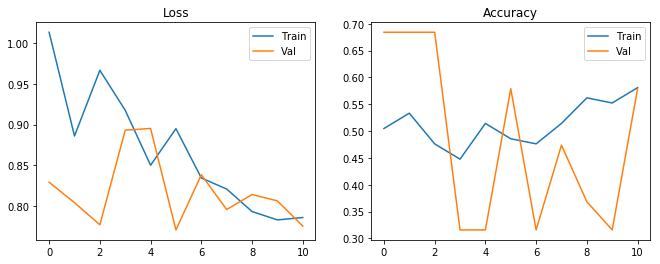

Trial 5
Epoch 1/200
27/27 [==============================] - 6s 235ms/step - loss: 1.0423 - acc: 0.4253 - val_loss: 0.8839 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 151ms/step - loss: 0.9280 - acc: 0.4078 - val_loss: 0.9173 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9094 - acc: 0.4356 - val_loss: 0.8895 - val_acc: 0.3158

Epoch 00003: val_acc improved from 0.31579 to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial5-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 165ms/step - loss: 0.8162 - acc: 0.5644 - val_loss: 0.8558 - val_acc: 0.3158

Epoch 00004: val_acc improved from 0.31579 to 0.31579, 

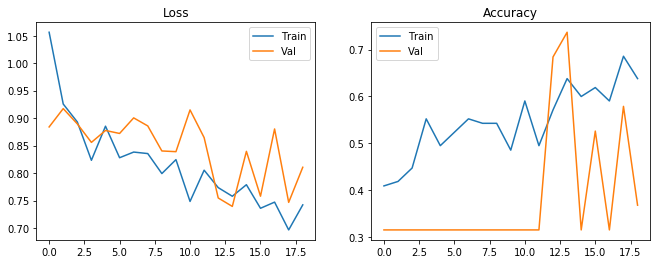

Trial 6
Epoch 1/200
27/27 [==============================] - 6s 236ms/step - loss: 0.9236 - acc: 0.4727 - val_loss: 0.8667 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 150ms/step - loss: 0.9392 - acc: 0.4531 - val_loss: 0.8212 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial6-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 153ms/step - loss: 0.8705 - acc: 0.4727 - val_loss: 0.9218 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 160ms/step - loss: 0.8853 - acc: 0.5180 - val_loss: 0.8229 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch

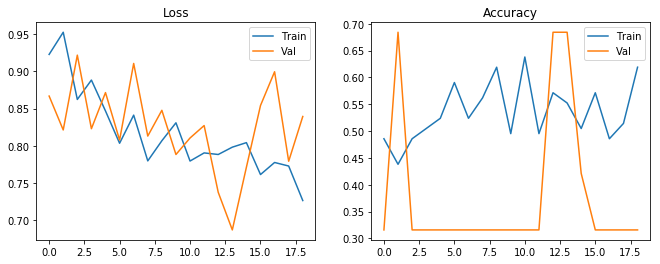

Trial 7
Epoch 1/200
27/27 [==============================] - 7s 256ms/step - loss: 0.9593 - acc: 0.5180 - val_loss: 1.0012 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9723 - acc: 0.4624 - val_loss: 0.8885 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 159ms/step - loss: 0.9106 - acc: 0.5180 - val_loss: 0.8007 - val_acc: 0.7368

Epoch 00003: val_acc improved from 0.31579 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial7-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 161ms/step - loss: 0.8726 - acc: 0.5366 - val_loss: 0.7833 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.73684
Epoch

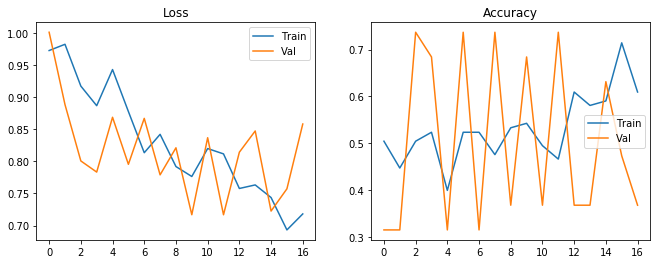

Trial 8
Epoch 1/200
27/27 [==============================] - 7s 258ms/step - loss: 1.0061 - acc: 0.4912 - val_loss: 1.0930 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 0.9474 - acc: 0.4634 - val_loss: 0.8423 - val_acc: 0.3684

Epoch 00002: val_acc improved from 0.31579 to 0.36842, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial8-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 151ms/step - loss: 0.8543 - acc: 0.5469 - val_loss: 0.8433 - val_acc: 0.3684

Epoch 00003: val_acc did not improve from 0.36842
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8740 - acc: 0.5366 - val_loss: 0.8846 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.36842
Epoch

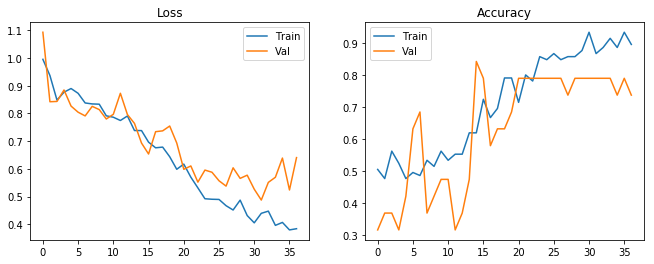

Trial 9
Epoch 1/200
27/27 [==============================] - 7s 277ms/step - loss: 1.0222 - acc: 0.5098 - val_loss: 0.8610 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.8741 - acc: 0.5458 - val_loss: 0.9428 - val_acc: 0.3158

Epoch 00002: val_acc improved from 0.31579 to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial9-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 153ms/step - loss: 0.8634 - acc: 0.5458 - val_loss: 0.8198 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial9-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 155ms/

27/27 [==============================] - 4s 152ms/step - loss: 0.3774 - acc: 0.9166 - val_loss: 0.5487 - val_acc: 0.8947

Epoch 00040: val_acc did not improve from 0.89474
Epoch 41/200
27/27 [==============================] - 4s 164ms/step - loss: 0.4096 - acc: 0.9073 - val_loss: 0.6261 - val_acc: 0.7895

Epoch 00041: val_acc did not improve from 0.89474
Epoch 42/200
27/27 [==============================] - 4s 166ms/step - loss: 0.3816 - acc: 0.9166 - val_loss: 0.6110 - val_acc: 0.7895

Epoch 00042: val_acc did not improve from 0.89474
Epoch 43/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3751 - acc: 0.8980 - val_loss: 0.6381 - val_acc: 0.7368

Epoch 00043: val_acc did not improve from 0.89474
Epoch 00043: early stopping


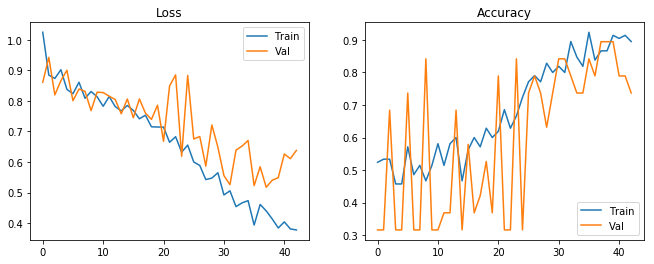

Training Time: 0.0h:15.0m:44.940659284591675s
Validation final accuracies: 
 [0.42105263471603394, 0.3157894752527538, 0.3157894752527538, 0.3157894752527538, 0.5789473684210527, 0.3684210526315789, 0.3157894752527538, 0.3684210542001222, 0.7368421052631579, 0.7368421052631579]
Validation final accuracies mean: 0.4473684221506119
Validation best accuracies: 
 [0.6842105294528761, 0.7894736842105263, 0.6842105294528761, 0.6842105263157895, 0.6842105278843328, 0.7368421052631579, 0.6842105294528761, 0.7368421084002444, 0.8421052631578947, 0.8947368452423498]
Validation best accuracies mean: 0.7421052648832924
Validation balanced accuracies: 
 [0.5769230769230769, 0.5, 0.5, 0.5, 0.4807692307692308, 0.5384615384615384, 0.5, 0.5384615384615384, 0.47435897435897434, 0.39743589743589747]
Validation balanced accuracies mean: 0.5006410256410256
Validation final sensitivities: 
 [1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333]
Validation final sensitivities' mean:

In [24]:
# training args
lr = 0.0005
lr_decay = 0.002
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=4, shuffle=True)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

In [25]:
training_time = time.time() - start_time

# Evaluation

In [26]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [27]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False)

In [28]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 47.83 %
Balanced accuracy 49.23 %
Sensitivity 38.46 %
Specificity 60.00 %
Fold 1
Model accuracy 43.48 %
Balanced accuracy 48.85 %
Sensitivity 7.69 %
Specificity 90.00 %
Fold 2
Model accuracy 43.48 %
Balanced accuracy 50.00 %
Sensitivity 0.00 %
Specificity 100.00 %
Fold 3
Model accuracy 43.48 %
Balanced accuracy 50.00 %
Sensitivity 0.00 %
Specificity 100.00 %
Fold 4
Model accuracy 43.48 %
Balanced accuracy 50.00 %
Sensitivity 0.00 %
Specificity 100.00 %
Fold 5
Model accuracy 65.22 %
Balanced accuracy 64.62 %
Sensitivity 69.23 %
Specificity 60.00 %
Fold 6
Model accuracy 39.13 %
Balanced accuracy 45.00 %
Sensitivity 0.00 %
Specificity 90.00 %
Fold 7
Model accuracy 47.83 %
Balanced accuracy 53.85 %
Sensitivity 7.69 %
Specificity 100.00 %
Fold 8
Model accuracy 69.57 %
Balanced accuracy 70.77 %
Sensitivity 61.54 %
Specificity 80.00 %
Fold 9
Model accuracy 86.96 %
Balanced accuracy 87.31 %
Sensitivity 84.62 %
Specificity 90.00 %
######## Final results ########
Accuracy mean 53.

In [29]:
total_time = time.time() - start_time

In [30]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.
Training Time: 0.0h:15.0m:44.956626892089844s
Total time elapsed: 0.0h:18.0m:1.1602394580841064s


In [31]:
quit()

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/IPython/core/history.py", line 780, in writeout_cache
    self._writeout_input_cache(conn)
  File "/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
    (self.session_number,)+line)
sqlite3.OperationalError: unable to open database file
